In [2]:

import pickle
import csv
import numpy as np
import glob
from sys import exit
from sklearn import preprocessing;
import matplotlib.pyplot as plt

In [26]:
Dataframe = [];
Dataframe_filename = 'SRI_collab/AutoSyn Data/Dataframe_imatinib_amide_methylpiperazine_higher_eq.csv'
with open(Dataframe_filename,newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    iter = 0;
    all_rows = [];
    for row in spamreader:
        if iter>1:
            try:
                row = [np.float(elem) for elem in row]
                all_rows.append(row)
            except:
                row;

        iter = iter+1;
    Dataframe.append(np.asarray(all_rows));

In [27]:
Dataframe = np.asarray(Dataframe).squeeze(axis=0)

In [38]:
all_temps = list(set(Dataframe[:,0]))
all_temps.sort();

In [43]:
all_ratios = list(set(Dataframe[:,2]))
all_ratios.sort();

In [60]:
set((0,1)).intersection( set((0,2)))


{0}

In [79]:
Dataframe[common_indices,[0,2]]

AttributeError: 'list' object has no attribute 'T'

In [87]:
row_iter = 0; 
All_Yglobals = [];
All_Uglobals = [];
All_Yps=[];
All_Yfs = [];
All_Ups=[]
for temp in all_temps:
    for ratio in all_ratios:
        this_ratio_idces = np.where(Dataframe[:,2]==ratio)[0];
        #print(this_ratio_idces)
        this_temp_idces = np.where(Dataframe[:,0]==temp)[0];
        common_indices = list(set(this_ratio_idces).intersection(set(this_temp_idces)));
        common_indices.sort();
        
        Raw_global = Dataframe[common_indices,:]
        Y_global = Dataframe[common_indices,6:14]
        U_global = Dataframe[:,[0,2]][common_indices,:]
        print(U_global.shape)
        Yp = Y_global[0:-1];
        Yf = Y_global[1:];
        Up = U_global[0:-1];
        
        All_Ups.append(Up);
        All_Yps.append(Yp);
        All_Yfs.append(Yf);
        
All_Up = np.vstack(All_Ups);
All_Yp = np.vstack(All_Yps);
All_Yf = np.vstack(All_Yfs);

(10, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)


(1209, 8)

In [4]:
def find_nearest(array, value):
    array = np.asarray(array)
    diff_array = (np.abs(array - value));
    idx = diff_array.argmin();
    return idx;

In [92]:
from sklearn import preprocessing;

this_Yp_scaler = preprocessing.MinMaxScaler()
this_Up_scaler = preprocessing.MinMaxScaler()


this_Yp_scaler.fit(All_Yp);
this_Up_scaler.fit(All_Up);

Yp_t = this_Yp_scaler.transform(All_Yp);
Yf_t = this_Yp_scaler.transform(All_Yf);
Up_t = this_Up_scaler.transform(All_Up);

(32, 7)

In [93]:
picklefile_path = './koopman_data/SRI_AutoSyn.pickle';
picklefile=open(picklefile_path,'wb')
pickle.dump([Yp_t,Yf_t,Up_t],picklefile)
picklefile.close()

In [94]:
from cvxpy import Minimize
from cvxpy import Minimize, Problem, Variable,norm1,installed_solvers,lambda_max;
from cvxpy import norm as cvxpynorm;
import cvxpy

def calc_Input_Koopman(Yf,Yp,Up,flag=1,lambda_val=0.0,PsiDelta_Mat=[]):
    solver_instance = cvxpy.SCS;
    Ki = None;
    if flag==1: # moore penrose inverse, plain ol' least squares input-Koopman
        #Yp_inv = np.dot(np.transpose(Yp_final), np.linalg.inv( np.dot(Yp_final,np.transpose(Yp_final)) )   );
        Yfprime = Yf-np.dot(Kol,Yp)
        Up_inv = np.linalg.pinv(Up);
        Ki = np.dot(Yfprime,Up_inv);
        

    if flag ==2: # cvx optimization approach - L2 + L1 lasso 
        norm1_term = 0.0;
        all_col_handles = [None]*Up.shape[0]

        for i in range(0,Up.shape[0]):
            all_col_handles[i] = Variable(shape=(Yf.shape[0],1)) ;#Variable(shape=(Yf.shape[0],1) );

        operator = cvxpy.hstack(all_col_handles);
        
        all_Kol_col_handles = [None]*Yp.shape[0];
        for i in range(0,Yp.shape[0]):
            all_Kol_col_handles[i] = Variable(shape=(Yp.shape[0],1)); 
        ol_operator = cvxpy.hstack(all_Kol_col_handles);
        
        
        if len(PsiDelta_Mat) == 0:
            if (type(lambda_val) == np.float):
                norm1_term =lambda_val*(cvxpy.norm(ol_operator,p='fro')+cvxpy.norm(operator,p='fro'));
            else:
                lambda_val = np.reshape(lambda_val,(len(lambda_val),1));
                Unoise = np.tile(lambda_val,(1,Up.shape[1]))
                norm1_term = cvxpy.norm(cvxpy.matmul(operator,Unoise),p='fro');
        else:
            norm1_term = cvxpy.norm(cvxpy.matmul(operator,PsiDelta_Mat),p='fro');
        
        norm2_fit_term = cvxpy.norm(cvxpy.norm(Yf-ol_operator*Yp-operator*Up,p=2,axis=0),p=2);
        objective = Minimize(norm2_fit_term + norm1_term)
        constraints = [];
        prob = Problem(objective,constraints);
        result = prob.solve(verbose=True,solver=solver_instance,max_iters=np.int(1e7))#,reltol=1e-10,abstol=1e-10);
        print("[INFO]: Finished executing cvx solver, printing CVXPY problem status")
        print(prob.status);
        Ki = operator.value;
        Kx = ol_operator.value;
    return Kx,Ki;

In [101]:
Kx,Ki = calc_Input_Koopman(Yf_t.T,Yp_t.T,Up_t.T,flag=2,lambda_val=0.00)

----------------------------------------------------------------------------
	SCS v2.1.0 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 87749
eps = 1.00e-04, alpha = 1.50, max_iters = 10000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 1292, constraints m = 12173
Cones:	soc vars: 12173, soc blks: 1212
Setup time: 2.51e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 4.77e+20  3.07e+20  1.00e+00 -1.46e+22  3.53e+19  7.35e+21  7.94e-03 
   100| 2.55e-04  3.54e-04  7.22e-04  7.62e-01  7.60e-01  2.13e-15  1.35e-01 
   180| 1.51e-05  7.25e-05  2.56e-05  7.60e-01  7.61e-01  9.41e-16  2.32e-01 
------------------------

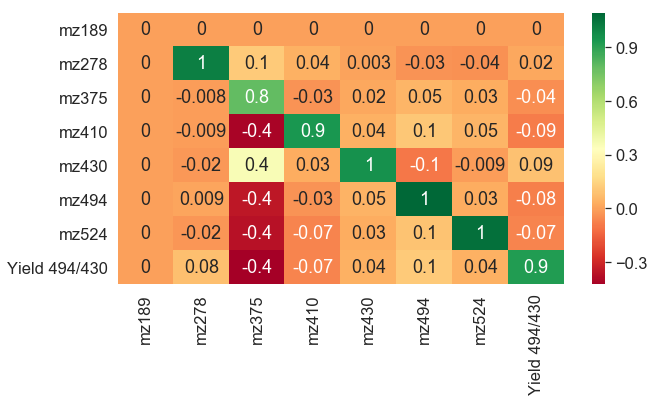

In [109]:
import seaborn as sns

this_ylabels = ['mz189','mz278','mz375','mz410','mz430','mz494','mz524','Yield 494/430']
import matplotlib
plt.figure(figsize=(10,5))
sns.set(font_scale=1.5)

hm = sns.heatmap(Kx,xticklabels=this_ylabels,yticklabels=this_ylabels,cmap='RdYlGn',fmt='0.1g',annot=True)


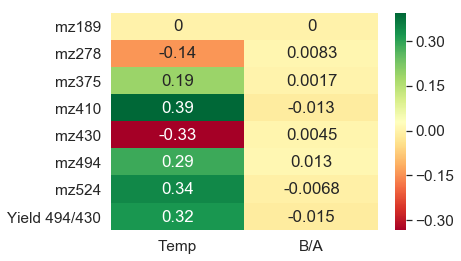

In [103]:
this_xlabels = ['Temp','B/A']
sns.set(font_scale=1.4)
hm=sns.heatmap(Ki,xticklabels=this_xlabels,yticklabels=this_ylabels,cmap='RdYlGn',annot=True)
